# Read in Pkg/Data

In [8]:
pip install seaborn

In [7]:
import pandas as pd
#import matplotlib.pyplot as plt
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

sns.set(style='whitegrid')


ModuleNotFoundError: No module named 'seaborn'

In [3]:
data = pd.read_csv("train.csv")
data.head()


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# Data Visualization

There are 381109 rows × 12 columns

All columns: id, Gender, Age, Driving_License, Region_Code, Previously_Insured', Vehicle_Age, 'Vehicle_Damage', 'Annual_Premium, Policy_Sales_Channel, Vintage(Days customer associated for with company), Response

Categorical(Binary) Columns: Gender, Driving_License, Previously_Insured, Vehicle_Damage
Categorical(Multiple) Columns: Region_Code, Policy_Sales_Channel

Countinuous Columns: Age, Vehicle_Age, Vintage

Treatment/Decision Variable(z): Annual_Premium

Response(Y): Response

In [18]:
data.columns.values

array(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype=object)

In [15]:
pd.DataFrame(data.describe()).T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
Age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
Driving_License,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
Region_Code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
Previously_Insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
Annual_Premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
Policy_Sales_Channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
Vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
Response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0


The youngest customer in our data is 20 years old, the oldest customer is 85 years old

The lowest annual premium is 2630/yr = 219/mth, the highest premium is 540165/yr = 45k/mth. Note that this currency(Indian Rupee) is in Rs. which is 1RS~0.012 Dollar

The lowest number of vintage is 10, the highest number is 299. Meaning all of the customer in our data are only with the company within a year.

In [50]:
pd.DataFrame(
    [data.dtypes,
     data.isnull().sum(),
     data.nunique()],
     index=["datatype","missing_value","unique_values"]
).T

,datatype,missing_value,unique_values
id,int64,0,381109
Gender,object,0,2
Age,int64,0,66
Driving_License,int64,0,2
Region_Code,float64,0,53
Previously_Insured,int64,0,2
Vehicle_Age,object,0,3
Vehicle_Damage,object,0,2
Annual_Premium,float64,0,48838
Policy_Sales_Channel,float64,0,155


In [51]:
#Anonymized Code for outreaching channel ie. Different Agents, Over Mail, Over Phone, In Person, etc.
data['Vehicle_Age'].value_counts()

Vehicle_Age
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: count, dtype: int64

For categorical columns, note the there are 155 different categories under policy sales channel. (this could due to a combination of different channels)

Veh Age is also treated as categorical

## Continuous Variables

<Axes: xlabel='Age', ylabel='Annual_Premium'>

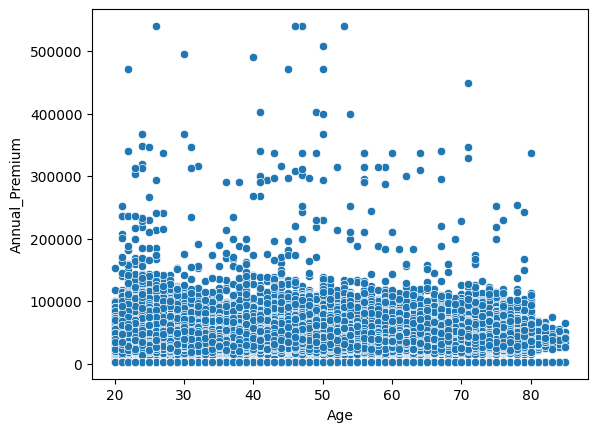

In [8]:
sns.scatterplot(x=data['Age'],y=data['Annual_Premium'])

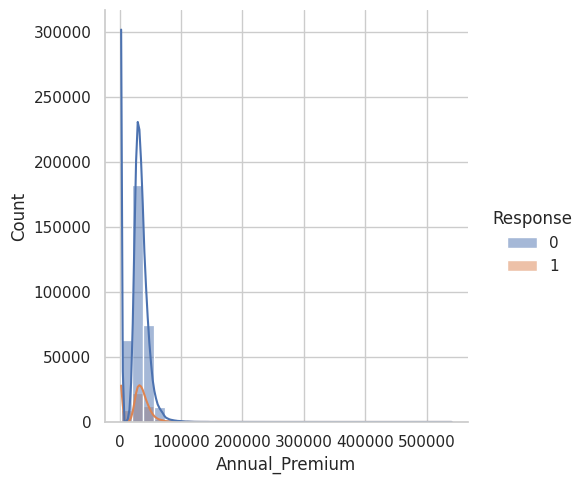

In [27]:
sns.displot(data, x='Annual_Premium', bins=30, hue="Response", kde=True)

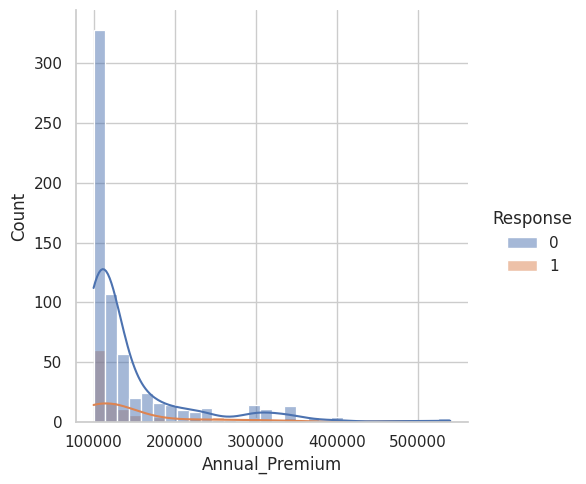

In [31]:
absurd_prem = data[data['Annual_Premium']>100000]
sns.displot(absurd_prem, x='Annual_Premium', bins=30, hue="Response", kde=True)

We can see that there are some extreme outliers in term of premium(our treatment)

In [4]:
print(data['Response'].value_counts())
print(data['Response'].value_counts(normalize=True))

Response
0    334399
1     46710
Name: count, dtype: int64
Response
0    0.877437
1    0.122563
Name: proportion, dtype: float64


# Data Processing

1. Change the categorical columns to object
2. Change the unit of currency to Dollar
3. Remove the Outliers(?) not sure if this is a appropriote thing to do for prescriptive analysis

In [4]:
# Bin_Ord_col = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Damage', 'Vehicle_Age']

# gender = {'Male': 0, 'Female': 1}
# driving_license = {0: 0, 1: 1}
# previously_insured = {0: 1, 1: 0}
# vehicle_age = {'> 2 Years': 2, '1-2 Year': 1, '< 1 Year': 0}
# vehicle_damage = {'Yes': 1, 'No': 0}

# data['Gender'] = data['Gender'].map(gender)
# data['Driving_License'] = data['Driving_License'].map(driving_license)
# data['Previously_Insured'] = data['Previously_Insured'].map(previously_insured)
# data['Vehicle_Age'] = data['Vehicle_Age'].map(vehicle_age)
# data['Vehicle_Damage'] = data['Vehicle_Damage'].map(vehicle_damage)

data['Vehicle_Age']=data['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})
data['Gender']=data['Gender'].replace({'Male':1,'Female':0})
data['Vehicle_Damage']=data['Vehicle_Damage'].replace({'Yes':1,'No':0})

Cat_col = ['Region_Code', 'Policy_Sales_Channel','Response']
for col in Cat_col:
    data[col]=data[col].astype('category')

# Prescriptive Analysis

In [5]:
X = data.drop(columns=['id', 'Response', 'Annual_Premium'], axis=1)
Y = data['Response']
Z = data['Annual_Premium']

In [6]:
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, Y, Z,
                                                    test_size=0.3,
                                                    random_state=0,
                                                    stratify=Y)

In [65]:
y_train.value_counts(normalize=True)

Response
0    0.877437
1    0.122563
Name: proportion, dtype: float64

## Baseline Model and Revenue

For the baseline, we simply use the test data premium, 

## Prescriptive Revenue

1. Using X to train a model to predict Y
- Logistic
- Knn
- Random Forest 
2. Optimize over y and treatment z

In [7]:
log_mod = LogisticRegression(max_iter=1000)
log_mod.fit(X_train, y_train)
log_mod_preds = log_mod.predict(X_test)

In [108]:
z_test.values[1].dtype

dtype('float64')

In [8]:
confusion_matrix(y_test,log_mod_preds)
accuracy = accuracy_score(y_test, log_mod_preds)
accuracy

0.8771920617844366

In [9]:
n = len(z_test)

In [11]:

model1 = gp.Model("model1")
z = model1.addVars(n, vtype=GRB.CONTINUOUS, name="z")

revenue = gp.quicksum(z[i] * log_mod_preds[i] for i in range(n))
model1.setObjective(revenue, GRB.MAXIMIZE)

# Constraint: maximum units that can be sold
model1.addConstrs(z[i] <= z_test.values[i]+10000 for i in range(n))
model1.optimize()

Set parameter Username


GurobiError: HostID mismatch (licensed to bc6950b0, hostid is 5d244e88)